# W4 Lab Exercise
This is the lab exercise for MIS590: Information Retrieval. </br>
In this lab, you will gain the following experience:</br>
- Understand Vector Space Models (VSMs) for Information Retrieval.
- Develop Practical Skills in Vector-Based Document Representation, Including TF-IDF, Word2Vec, and BERT.
- Compare the Effectiveness of Different Term Weighting Schemes.
- Enhance Analytical Thinking in Evaluating IR Models
</br>

**Note:** When you see a pencil icon ✏️ in this notebook, it's time for you to code!

# 1. Preliminaries

## 1.1 Install and Import Libraries

In [47]:
# Install the necessary packages
# !pip install nltk
# !pip install torch
# !pip install numpy
# !pip install gensim
# !pip install string
# !pip install transformers
# !pip install scikit-learn

In [1]:
import math
import string
from collections import defaultdict

## 1.2 Input: Query & Document Collections (Corpus)

In [2]:
query = "sleep deprivation"

corpus = [
    "Sleepless nights in the lab have become my new normal. I tried to fix the experiment setup, but the apparatus seems to have a mind of its own. My advisor says results are just around the corner, but the corner keeps moving. Coffee is my only true companion these days.",
    "I thought grad school would be intellectually stimulating, but it's mostly paperwork and waiting for emails. The departmental printer jammed again, and now I'm late for a meeting. The cafeteria ran out of the good snacks, so I'm surviving on vending machine chips. Sleep has become a luxury I can no longer afford.",
    "Writing the dissertation feels like climbing an endless mountain. Every time I finish a chapter, my supervisor suggests new revisions. The impostor syndrome is real, and I wonder if they made a mistake accepting me. Maybe I should have gone to clown college instead. I am utterly deprived of any semblance of a normal life.",
    "My research data got corrupted, and now I have to start over. The lab mouse escaped, and we spent hours trying to find it. The grant proposal deadline is tomorrow, and the online submission portal is down. At least my pet cactus hasn't died yet.",
    "The group meeting turned into a three-hour debate over font choices for the presentation. I'm pretty sure my colleague is stealing my lunch from the fridge. The photocopier is out to get me; it never works when I'm in a hurry. Is there a PhD in napping? Because I'd ace that.",
    "I haven't seen the sun in days due to endless coding sessions. The simulation keeps crashing, and Stack Overflow doesn't have the answers. My roommate thinks I'm a ghost haunting the apartment. Instant noodles have become my primary food group.",
    "Attending conferences sounded fun until I realized they involve a lot of awkward networking. I accidentally spilled coffee on a famous professor's shoes. My poster fell down twice during the session. Next time, I'll just send a cardboard cutout of myself.",
    "The university gym membership was supposed to keep me healthy, but I've only used it once. I tried to attend a yoga class after staying up late for a deadline, but I fell asleep during the meditation. Maybe instead of the gym, my bed is more essential for keeping me healthy.",
    "My teaching assistantship involves grading endless stacks of exams. Students keep emailing me for extensions with creative excuses. One claimed their dog sleeps on the laptop so they cannot use it for the exam. I was deprived of excuses for not completing my dissertation draft, and I might have got some good ones.",
    "Group projects are the worst when you're the only one doing the work. My team members are as elusive as Bigfoot. The project is due next week, and I haven't heard from them. Perhaps I should just write a paper on the sociological implications of group work avoidance."
]

# Binary labels for the documents' relevancy to the query
# Relevant ones: 1, 2, 5, 6, 8
corpus_relevancy_label = [1, 1, 0, 0, 1, 1, 0, 1, 0, 0]

In [3]:
print(f"Query: {query}\n")
for idx, doc in enumerate(corpus):
    print(f"Document {idx+1}:\n{doc}\n")

Query: sleep deprivation

Document 1:
Sleepless nights in the lab have become my new normal. I tried to fix the experiment setup, but the apparatus seems to have a mind of its own. My advisor says results are just around the corner, but the corner keeps moving. Coffee is my only true companion these days.

Document 2:
I thought grad school would be intellectually stimulating, but it's mostly paperwork and waiting for emails. The departmental printer jammed again, and now I'm late for a meeting. The cafeteria ran out of the good snacks, so I'm surviving on vending machine chips. Sleep has become a luxury I can no longer afford.

Document 3:
Writing the dissertation feels like climbing an endless mountain. Every time I finish a chapter, my supervisor suggests new revisions. The impostor syndrome is real, and I wonder if they made a mistake accepting me. Maybe I should have gone to clown college instead. I am utterly deprived of any semblance of a normal life.

Document 4:
My research dat

# 2. Vector Space Model: TF-IDF

## 2.1 Data Preprocessing

### Steps for textual data preprocessing
1. Tokenization (= word segmentation)
2. Punctualtion and non-alphabetic token removal
3. Stopwords removal
4. Lemmatization / stemming

### Import libraries

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet as wn

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eddie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eddie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\eddie\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eddie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Initialize stopwords, lemmatizer, and punctuation list
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
punctuation_table = str.maketrans('', '', string.punctuation)

# We will use this sentence as example to showcase the different steps of data preprocessing
example_sentence = "The graduate student was typing, procrastinating, questioning herself, and finally submitting the dissertation while dreaming about sleep."
print(f"Example Sentence:\n{example_sentence}")

Example Sentence:
The graduate student was typing, procrastinating, questioning herself, and finally submitting the dissertation while dreaming about sleep.


### What is tokenization?

In [6]:
tokens = word_tokenize(example_sentence.lower())
print(tokens)

['the', 'graduate', 'student', 'was', 'typing', ',', 'procrastinating', ',', 'questioning', 'herself', ',', 'and', 'finally', 'submitting', 'the', 'dissertation', 'while', 'dreaming', 'about', 'sleep', '.']


### A quick removal of punctualtions and non-alphabetic words

In [7]:
tokens_noPunc = [word.translate(punctuation_table) for word in tokens if word.isalpha()]
print(tokens_noPunc)

['the', 'graduate', 'student', 'was', 'typing', 'procrastinating', 'questioning', 'herself', 'and', 'finally', 'submitting', 'the', 'dissertation', 'while', 'dreaming', 'about', 'sleep']


### What are stopwords?

In [8]:
tokens_noSW = [word for word in tokens_noPunc if word not in stop_words]
print(tokens_noSW)

['graduate', 'student', 'typing', 'procrastinating', 'questioning', 'finally', 'submitting', 'dissertation', 'dreaming', 'sleep']


### What is lemmatization?

In [9]:
print("Original\tLemmatized\n")

# Here we use pre-stopword removal tokens
lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens_noSW]
for ori, lem in zip(tokens_noSW, lemmatized_tokens):
    print(f"{ori}\t{lem}")

Original	Lemmatized

graduate	graduate
student	student
typing	typing
procrastinating	procrastinating
questioning	questioning
finally	finally
submitting	submitting
dissertation	dissertation
dreaming	dreaming
sleep	sleep


### Observe the results above and discuss the following:
- What is lemmatization?
- I guess you cannot tell what lemmatization is from the results above. Let's try lemmatization in another way.

### How about we tell the lemmatizer more information of the tokens?

In [10]:
# Part-of-Speech Tagging
tagged_tokens = pos_tag(tokens)
print(tagged_tokens)

[('the', 'DT'), ('graduate', 'NN'), ('student', 'NN'), ('was', 'VBD'), ('typing', 'VBG'), (',', ','), ('procrastinating', 'VBG'), (',', ','), ('questioning', 'VBG'), ('herself', 'PRP'), (',', ','), ('and', 'CC'), ('finally', 'RB'), ('submitting', 'VBG'), ('the', 'DT'), ('dissertation', 'NN'), ('while', 'IN'), ('dreaming', 'VBG'), ('about', 'RB'), ('sleep', 'NN'), ('.', '.')]


### Then we do the punctuation, non-alphabetic tokens, and stopword removal.

In [11]:
# Remove punctuation and non-alphabetic tokens
tagged_tokens_noPunc = [(word[0].translate(punctuation_table), word[1]) for word in tagged_tokens if word[0].isalpha()]
print(tagged_tokens_noPunc)

# Remove stopwords
tagged_tokens_noSW = [(word[0], word[1]) for word in tagged_tokens_noPunc if word[0] not in stop_words]
print(tagged_tokens_noSW)

[('the', 'DT'), ('graduate', 'NN'), ('student', 'NN'), ('was', 'VBD'), ('typing', 'VBG'), ('procrastinating', 'VBG'), ('questioning', 'VBG'), ('herself', 'PRP'), ('and', 'CC'), ('finally', 'RB'), ('submitting', 'VBG'), ('the', 'DT'), ('dissertation', 'NN'), ('while', 'IN'), ('dreaming', 'VBG'), ('about', 'RB'), ('sleep', 'NN')]
[('graduate', 'NN'), ('student', 'NN'), ('typing', 'VBG'), ('procrastinating', 'VBG'), ('questioning', 'VBG'), ('finally', 'RB'), ('submitting', 'VBG'), ('dissertation', 'NN'), ('dreaming', 'VBG'), ('sleep', 'NN')]


### Take 2: what is lemmatization?

In [12]:
# Convert treebank POS tags to wordnet POS tags so the lemmatizer can read them
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN

print("Original\tLemmatized\n")
tagged_tokens_lemmatized = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in tagged_tokens_noSW]
for ori, lem in zip(tagged_tokens_noSW, tagged_tokens_lemmatized):
    print(f"{ori[0]}\t{lem}")

Original	Lemmatized

graduate	graduate
student	student
typing	type
procrastinating	procrastinate
questioning	question
finally	finally
submitting	submit
dissertation	dissertation
dreaming	dream
sleep	sleep


### Observe the results above and discuss the following:
- What is lemmatization?

### What is stemming?

In [13]:
print("Original\tStemmed\n")
tokens_stemmed = [stemmer.stem(word) for word in tagged_tokens_lemmatized]
for ori, stem in zip(tagged_tokens_lemmatized, tokens_stemmed):
    print(f"{ori}\t{stem}")

Original	Stemmed

graduate	graduat
student	student
type	type
procrastinate	procrastin
question	question
finally	final
submit	submit
dissertation	dissert
dream	dream
sleep	sleep


### Observe the results above and discuss the following:
- What is stemming?
- Why is stemming helpful in imporving TF-IDF performance?

### ✏️ Now let's preprocess the query and the documents!

In [14]:
# TODO
# Preprocessing function
def preprocess_text(text):
    
    # Step 1: # Convert to lowercase and tokenize text into words
    tokens = word_tokenize(text.lower())
    
    # Step 2: Tag part-of-speech of the tokens
    tokens = pos_tag(tokens)
    
    # Step 3: Remove punctuation and non-alphabetic tokens
    tokens = [(word[0].translate(punctuation_table), word[1]) for word in tokens if word[0].isalpha()]
    
    # Step 4: Remove stopwords
    tokens = [(word[0], word[1]) for word in tokens if word[0] not in stop_words]
    
    # Step 5: Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in tokens]
    
    # Step 6: Stem tokens
    tokens = [stemmer.stem(word) for word in tokens]
    
    return tokens

In [15]:
# Apply preprocessing to each document in the corpus
preprocessed_query = preprocess_text(query)
print(f"Query: {preprocessed_query}\n")

preprocessed_corpus = [preprocess_text(doc) for doc in corpus]
# Print preprocessed corpus
for idx, doc in enumerate(preprocessed_corpus):
    print(f"Document {idx+1}: {doc}")

Query: ['sleep', 'depriv']

Document 1: ['sleepless', 'night', 'lab', 'becom', 'new', 'normal', 'tri', 'fix', 'experi', 'setup', 'apparatu', 'seem', 'mind', 'advisor', 'say', 'result', 'around', 'corner', 'corner', 'keep', 'move', 'coffe', 'true', 'companion', 'day']
Document 2: ['think', 'grad', 'school', 'would', 'intellectu', 'stimul', 'mostli', 'paperwork', 'wait', 'email', 'department', 'printer', 'jam', 'late', 'meet', 'cafeteria', 'run', 'good', 'snack', 'surviv', 'vend', 'machin', 'chip', 'sleep', 'becom', 'luxuri', 'longer', 'afford']
Document 3: ['write', 'dissert', 'feel', 'like', 'climb', 'endless', 'mountain', 'everi', 'time', 'finish', 'chapter', 'supervisor', 'suggest', 'new', 'revis', 'impostor', 'syndrom', 'real', 'wonder', 'make', 'mistak', 'accept', 'mayb', 'go', 'clown', 'colleg', 'instead', 'utterli', 'depriv', 'semblanc', 'normal', 'life']
Document 4: ['research', 'data', 'get', 'corrupt', 'start', 'lab', 'mous', 'escap', 'spend', 'hour', 'tri', 'find', 'grant', '

## ✏️ 2.2 Compute Term Frequency (TF)

In [16]:
# Function to compute term frequency (TF) for each document
def compute_tf(doc):
    
    # Initialize the TF dictionary
    tf_dict = {}
    
    # TODO
    # Count the term frequency 
    for word in doc:
        tf_dict[word] = tf_dict.get(word, 0) + 1
    
    # TODO
    # Divide term counts by total number of terms in the document
    total_terms = len(doc)
    for word in tf_dict:
        tf_dict[word] = tf_dict[word] / total_terms
    
    return tf_dict

# Compute TF for each document in the corpus
tf_corpus = [compute_tf(doc) for doc in preprocessed_corpus]

# Print TF values for each document
for idx, tf in enumerate(tf_corpus):
    print(f"TF for Document {idx+1}: {tf}\n")

TF for Document 1: {'sleepless': 0.04, 'night': 0.04, 'lab': 0.04, 'becom': 0.04, 'new': 0.04, 'normal': 0.04, 'tri': 0.04, 'fix': 0.04, 'experi': 0.04, 'setup': 0.04, 'apparatu': 0.04, 'seem': 0.04, 'mind': 0.04, 'advisor': 0.04, 'say': 0.04, 'result': 0.04, 'around': 0.04, 'corner': 0.08, 'keep': 0.04, 'move': 0.04, 'coffe': 0.04, 'true': 0.04, 'companion': 0.04, 'day': 0.04}

TF for Document 2: {'think': 0.03571428571428571, 'grad': 0.03571428571428571, 'school': 0.03571428571428571, 'would': 0.03571428571428571, 'intellectu': 0.03571428571428571, 'stimul': 0.03571428571428571, 'mostli': 0.03571428571428571, 'paperwork': 0.03571428571428571, 'wait': 0.03571428571428571, 'email': 0.03571428571428571, 'department': 0.03571428571428571, 'printer': 0.03571428571428571, 'jam': 0.03571428571428571, 'late': 0.03571428571428571, 'meet': 0.03571428571428571, 'cafeteria': 0.03571428571428571, 'run': 0.03571428571428571, 'good': 0.03571428571428571, 'snack': 0.03571428571428571, 'surviv': 0.03

## ✏️ 2.3 Compute Inverse Document Frequency (IDF)

In [17]:
# Function to compute inverse document frequency (IDF) for each term in the corpus
def compute_idf(corpus):
    
    N = len(corpus)  # Total number of documents
    
    # Initialize the IDF dictionary
    idf_dict = defaultdict(int)
    
    # TODO
    # Count the number of documents containing each word
    for doc in corpus:
        for word in set(doc):  # Use set to count each word only once per document
            idf_dict[word] += 1
    
    #TODO
    # Compute IDF (logarithmic scale)
    for word in idf_dict:
        idf_dict[word] = math.log(N / (idf_dict[word])) + 1  # Smoothing by adding 1
    
    return idf_dict

# Compute IDF for the corpus
idf_dict = compute_idf(preprocessed_corpus)

# Print IDF values
print("IDF for Corpus:")
for word, idf in idf_dict.items():
    print(f"{word}: {idf}")

IDF for Corpus:
apparatu: 3.302585092994046
advisor: 3.302585092994046
becom: 2.203972804325936
move: 3.302585092994046
result: 3.302585092994046
tri: 2.203972804325936
setup: 3.302585092994046
new: 2.6094379124341005
true: 3.302585092994046
lab: 2.6094379124341005
experi: 3.302585092994046
corner: 3.302585092994046
coffe: 2.6094379124341005
say: 3.302585092994046
normal: 2.6094379124341005
keep: 1.916290731874155
sleepless: 3.302585092994046
seem: 3.302585092994046
around: 3.302585092994046
companion: 3.302585092994046
day: 2.6094379124341005
fix: 3.302585092994046
mind: 3.302585092994046
night: 3.302585092994046
printer: 3.302585092994046
department: 3.302585092994046
chip: 3.302585092994046
stimul: 3.302585092994046
paperwork: 3.302585092994046
longer: 3.302585092994046
afford: 3.302585092994046
school: 3.302585092994046
mostli: 3.302585092994046
email: 2.6094379124341005
meet: 2.6094379124341005
grad: 3.302585092994046
jam: 3.302585092994046
machin: 3.302585092994046
wait: 3.302585

## ✏️ 2.4 Compute TF-IDF

In [18]:
# Function to compute TF-IDF for a document
def compute_tfidf(tf_doc, idf_dict):
    
    # Initialize TF-IDF dictionary
    tfidf_dict = {}
    
    # TODO
    # Multiply TF by corresponding IDF
    for word, tf_value in tf_doc.items():
        tfidf_dict[word] = tf_value * idf_dict.get(word, 0)  # Multiply TF by corresponding IDF
        
    return tfidf_dict

# Compute TF-IDF for each document in the corpus
tfidf_corpus = [compute_tfidf(tf, idf_dict) for tf in tf_corpus]

# Print TF-IDF values for each document
for idx, tfidf in enumerate(tfidf_corpus):
    print(f"TF-IDF for Document {idx+1}: {tfidf}\n")


TF-IDF for Document 1: {'sleepless': 0.13210340371976184, 'night': 0.13210340371976184, 'lab': 0.10437751649736403, 'becom': 0.08815891217303744, 'new': 0.10437751649736403, 'normal': 0.10437751649736403, 'tri': 0.08815891217303744, 'fix': 0.13210340371976184, 'experi': 0.13210340371976184, 'setup': 0.13210340371976184, 'apparatu': 0.13210340371976184, 'seem': 0.13210340371976184, 'mind': 0.13210340371976184, 'advisor': 0.13210340371976184, 'say': 0.13210340371976184, 'result': 0.13210340371976184, 'around': 0.13210340371976184, 'corner': 0.2642068074395237, 'keep': 0.0766516292749662, 'move': 0.13210340371976184, 'coffe': 0.10437751649736403, 'true': 0.13210340371976184, 'companion': 0.13210340371976184, 'day': 0.10437751649736403}

TF-IDF for Document 2: {'think': 0.09319421115836073, 'grad': 0.1179494676069302, 'school': 0.1179494676069302, 'would': 0.1179494676069302, 'intellectu': 0.1179494676069302, 'stimul': 0.1179494676069302, 'mostli': 0.1179494676069302, 'paperwork': 0.117949

## 2.5 The Implementaion of Information Retrieval System

### Measuring similarity: cosine similarity

In [19]:
# Function to compute cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    dot_product = sum(vec1.get(word, 0) * vec2.get(word, 0) for word in vec1)
    magnitude1 = math.sqrt(sum([value ** 2 for value in vec1.values()]))
    magnitude2 = math.sqrt(sum([value ** 2 for value in vec2.values()]))
    
    if not magnitude1 or not magnitude2:
        return 0.0
    return dot_product / (magnitude1 * magnitude2)

### Rank the documents using cosine similarity

In [20]:
# Compute TF for the query
tf_query = compute_tf(preprocessed_query)

# Compute TF-IDF for the query
tfidf_query = compute_tfidf(tf_query, idf_dict)

# Compute the cosine similarity of each documents to the query
rankings_tfidf = []
for idx, tfidf_doc in enumerate(tfidf_corpus):
    score = cosine_similarity(tfidf_doc, tfidf_query)
    rankings_tfidf.append((idx + 1, score))

# Sort documents by similarity score in descending order
rankings_tfidf = sorted(rankings_tfidf, key=lambda x: x[1], reverse=True)

# Print document rankings
print("Document Rankings based on Query:")
for rank, (doc_idx, score) in enumerate(rankings_tfidf, start=1):
    print(f"Rank {rank}: Document {doc_idx} with score {score}")


Document Rankings based on Query:
Rank 1: Document 9 with score 0.20850879673278558
Rank 2: Document 2 with score 0.11131520312033671
Rank 3: Document 3 with score 0.10476487421443352
Rank 4: Document 1 with score 0.0
Rank 5: Document 4 with score 0.0
Rank 6: Document 5 with score 0.0
Rank 7: Document 6 with score 0.0
Rank 8: Document 7 with score 0.0
Rank 9: Document 8 with score 0.0
Rank 10: Document 10 with score 0.0


### Observe the results above and discuss the following:
- Are the highly ranked documents relevant to the query?
- Why?

# 3. Vector Space Model: Word2Vec

## 3.1 Import Libraries

In [21]:
import numpy as np
import gensim.downloader as api
from gensim.models import Word2Vec

## 3.2 Load Pre-trained Word2Vec Model

In [22]:
# Load the pre-trained Google News Word2Vec model
# This might take a while
model = api.load('word2vec-google-news-300')

### Let's observe a Word2Vec vector

In [23]:
model['apple']

array([-0.06445312, -0.16015625, -0.01208496,  0.13476562, -0.22949219,
        0.16210938,  0.3046875 , -0.1796875 , -0.12109375,  0.25390625,
       -0.01428223, -0.06396484, -0.08056641, -0.05688477, -0.19628906,
        0.2890625 , -0.05151367,  0.14257812, -0.10498047, -0.04736328,
       -0.34765625,  0.35742188,  0.265625  ,  0.00188446, -0.01586914,
        0.00195312, -0.35546875,  0.22167969,  0.05761719,  0.15917969,
        0.08691406, -0.0267334 , -0.04785156,  0.23925781, -0.05981445,
        0.0378418 ,  0.17382812, -0.41796875,  0.2890625 ,  0.32617188,
        0.02429199, -0.01647949, -0.06494141, -0.08886719,  0.07666016,
       -0.15136719,  0.05249023, -0.04199219, -0.05419922,  0.00108337,
       -0.20117188,  0.12304688,  0.09228516,  0.10449219, -0.00408936,
       -0.04199219,  0.01409912, -0.02111816, -0.13476562, -0.24316406,
        0.16015625, -0.06689453, -0.08984375, -0.07177734, -0.00595093,
       -0.00482178, -0.00089264, -0.30664062, -0.0625    ,  0.07

### Observe the results above and discuss the following:
- What is the data type of this vector?
- What is the dimensionality?

### Finding analogies using Word2Vec

In [24]:
model.most_similar("apple")

[('apples', 0.720359742641449),
 ('pear', 0.6450697183609009),
 ('fruit', 0.6410146355628967),
 ('berry', 0.6302295327186584),
 ('pears', 0.613396167755127),
 ('strawberry', 0.6058260798454285),
 ('peach', 0.6025872826576233),
 ('potato', 0.5960935354232788),
 ('grape', 0.5935863852500916),
 ('blueberry', 0.5866668224334717)]

In [25]:
model.most_similar("Apple")

[('Apple_AAPL', 0.7456986308097839),
 ('Apple_Nasdaq_AAPL', 0.7300410270690918),
 ('Apple_NASDAQ_AAPL', 0.717508852481842),
 ('Apple_Computer', 0.7145972847938538),
 ('iPhone', 0.6924266219139099),
 ('Apple_NSDQ_AAPL', 0.6868603229522705),
 ('Steve_Jobs', 0.6758421659469604),
 ('iPad', 0.6580768823623657),
 ('Apple_nasdaq_AAPL', 0.6444970369338989),
 ('AAPL_PriceWatch_Alert', 0.6439753174781799)]

In [26]:
model.most_similar(positive=['Gates', 'Apple'], negative=['Jobs'])

[('Microsoft', 0.457754522562027),
 ('Steve_Ballmer', 0.42643362283706665),
 ('Robert_Gates', 0.40924885869026184),
 ('Ballmer', 0.40724438428878784),
 ('Mullen', 0.4004097878932953),
 ('Chief_Executive_Steve_Ballmer', 0.3993479311466217),
 ('BlackBerry_maker', 0.39889541268348694),
 ('Apple_Nasdaq_AAPL', 0.39581313729286194),
 ('REDMOND_Wash._Microsoft', 0.3908952474594116),
 ('McAfee', 0.38951441645622253)]

## 3.3 Compute Word2Vec Embeddings

In [27]:
# Notice here we only tokenize and lowercase the tokens:
tokens = [word_tokenize(doc.lower()) for doc in corpus]
query_tokens = word_tokenize(query.lower())

# Function to compute the average word vector for a document or query
def compute_avg_vector(words, model):
    vectors = [model[word] for word in words if word in model]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # Return zero vector if no word in model

# Compute average word vectors for each document
doc_vectors = [compute_avg_vector(doc, model) for doc in tokens]

# Compute average word vector for the query
query_vector = compute_avg_vector(query_tokens, model)

## 3.4 The Implementaion of Information Retrieval System

### Measuring similarity: cosine similarity

In [28]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    magnitude1 = np.linalg.norm(vec1)
    magnitude2 = np.linalg.norm(vec2)
    
    if magnitude1 == 0 or magnitude2 == 0:
        return 0  # Avoid division by zero
    return dot_product / (magnitude1 * magnitude2)

### ✏️ Rank the documents using cosine similarity

In [29]:
# TODO
# Rank documents based on similarity to the query
rankings_word2vec = []
for idx, doc_vector in enumerate(doc_vectors):
    score = cosine_similarity(doc_vector, query_vector)
    rankings_word2vec.append((idx + 1, score))

# TODO
# Sort documents by similarity score in descending order
rankings_word2vec = sorted(rankings_word2vec, key=lambda x: x[1], reverse=True)

# Print document rankings
print("Document Rankings based on Query:")
for rank, (doc_idx, score) in enumerate(rankings_word2vec, start=1):
    print(f"Rank {rank}: Document {doc_idx} with score {score}")

Document Rankings based on Query:
Rank 1: Document 9 with score 0.3664294183254242
Rank 2: Document 8 with score 0.35598620772361755
Rank 3: Document 6 with score 0.35288575291633606
Rank 4: Document 3 with score 0.34057316184043884
Rank 5: Document 2 with score 0.32652580738067627
Rank 6: Document 1 with score 0.30051565170288086
Rank 7: Document 5 with score 0.2849697172641754
Rank 8: Document 10 with score 0.27993154525756836
Rank 9: Document 4 with score 0.2621768116950989
Rank 10: Document 7 with score 0.24750055372714996


### Observe the results above and discuss the following:
- How are the results using Word2Vec different from those using TF-IDF?

### How about we learn our own word2vec model with the corpus?

## 3.5 Train Word2Vec Model from Scratch

In [30]:
# Train Word2Vec on the corpus
model_corpus = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4)

In [31]:
# Function to compute the average word vector for a document or query
def compute_avg_vector(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # Return zero vector if no word in model

# Compute average word vectors for each document
doc_vectors = [compute_avg_vector(doc, model_corpus) for doc in tokens]

# Compute average word vector for the query
query_vector = compute_avg_vector(query_tokens, model_corpus)


In [32]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    magnitude1 = np.linalg.norm(vec1)
    magnitude2 = np.linalg.norm(vec2)
    
    if magnitude1 == 0 or magnitude2 == 0:
        return 0  # Avoid division by zero
    return dot_product / (magnitude1 * magnitude2)

# Rank documents based on similarity to the query
rankings_word2vec_trained = []
for idx, doc_vector in enumerate(doc_vectors):
    score = cosine_similarity(doc_vector, query_vector)
    rankings_word2vec_trained.append((idx + 1, score))

# Sort documents by similarity score in descending order
rankings_word2vec_trained = sorted(rankings_word2vec_trained, key=lambda x: x[1], reverse=True)

# Print document rankings
print("Document Rankings based on Query:")
for rank, (doc_idx, score) in enumerate(rankings_word2vec_trained, start=1):
    print(f"Rank {rank}: Document {doc_idx} with score {score}")

Document Rankings based on Query:
Rank 1: Document 9 with score 0.2207733392715454
Rank 2: Document 5 with score 0.21063056588172913
Rank 3: Document 2 with score 0.18398788571357727
Rank 4: Document 6 with score 0.12987695634365082
Rank 5: Document 7 with score 0.11967610567808151
Rank 6: Document 4 with score 0.10431124269962311
Rank 7: Document 1 with score 0.08538193255662918
Rank 8: Document 3 with score 0.06317423284053802
Rank 9: Document 10 with score 0.059812527149915695
Rank 10: Document 8 with score 0.02246975153684616


### Observe the results above and discuss the following:
- How are the results using self-trained Word2Vec different from those using pre-trained Word2Vec?

# 4. Vector Space Model: BERT
This is not how a BERT model is normally used, but we can see how contextualized embeddings are helpful in matching queries and documents beyond just words.

## 4.1 Import Libraries

In [33]:
import torch
from transformers import BertTokenizer, BertModel

## 4.2 Load Pre-trained BERT Model

In [34]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')

# Function to generate BERT embeddings for a given text
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model_bert(**inputs)
    # The [CLS] token embedding is typically used as the sentence representation
    return outputs.last_hidden_state[:, 0, :]  # Return the embedding for the [CLS] token

C:\Users\eddie\.conda\envs\DocumentClassification\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## 4.3 Compute BERT Embeddings

In [35]:
# Compute BERT embeddings for the query
query_embedding = get_bert_embedding(query)

# Compute BERT embeddings for each document in the corpus
corpus_embeddings = [get_bert_embedding(doc) for doc in corpus]

## 4.4 The Implementaion of Information Retrieval System

### Measuring similarity: cosine similarity

In [36]:
# Function to compute cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    vec1 = vec1.numpy()
    vec2 = vec2.numpy()
    dot_product = np.dot(vec1, vec2.T)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    
    if norm1 == 0 or norm2 == 0:
        return 0.0
    return dot_product / (norm1 * norm2)

### Rank the documents using cosine similarity

In [37]:
# Rank documents based on similarity to the query
rankings_bert = []
for idx, doc_embedding in enumerate(corpus_embeddings):
    score = cosine_similarity(query_embedding[0], doc_embedding[0])
    rankings_bert.append((idx + 1, score))

# Sort documents by similarity score in descending order
rankings_bert = sorted(rankings_bert, key=lambda x: x[1], reverse=True)

# Print document rankings
print("Document Rankings based on BERT embeddings:")
for rank, (doc_idx, score) in enumerate(rankings_bert, start=1):
    print(f"Rank {rank}: Document {doc_idx} with score {score}")

Document Rankings based on BERT embeddings:
Rank 1: Document 2 with score 0.8103367686271667
Rank 2: Document 6 with score 0.7880859971046448
Rank 3: Document 5 with score 0.7864929437637329
Rank 4: Document 3 with score 0.7857745885848999
Rank 5: Document 1 with score 0.7844799160957336
Rank 6: Document 10 with score 0.7754190564155579
Rank 7: Document 7 with score 0.7519575953483582
Rank 8: Document 8 with score 0.7409098148345947
Rank 9: Document 4 with score 0.7397841215133667
Rank 10: Document 9 with score 0.7047692537307739


### Observe the results above and discuss the following:
- How are the results using contextualized word embeddings (BERT) different from those using Word2Vec?

# Assignment 1

## Part 1: Implement Bigram TF-IDF
Using the same query and corpus, implement your own information retrival system base on bigram TF-IDF.

In [38]:
query = "sleep deprivation"

corpus = [
    "Sleepless nights in the lab have become my new normal. I tried to fix the experiment setup, but the apparatus seems to have a mind of its own. My advisor says results are just around the corner, but the corner keeps moving. Coffee is my only true companion these days.",
    "I thought grad school would be intellectually stimulating, but it's mostly paperwork and waiting for emails. The departmental printer jammed again, and now I'm late for a meeting. The cafeteria ran out of the good snacks, so I'm surviving on vending machine chips. Sleep has become a luxury I can no longer afford.",
    "Writing the dissertation feels like climbing an endless mountain. Every time I finish a chapter, my supervisor suggests new revisions. The impostor syndrome is real, and I wonder if they made a mistake accepting me. Maybe I should have gone to clown college instead. I am utterly deprived of any semblance of a normal life.",
    "My research data got corrupted, and now I have to start over. The lab mouse escaped, and we spent hours trying to find it. The grant proposal deadline is tomorrow, and the online submission portal is down. At least my pet cactus hasn't died yet.",
    "The group meeting turned into a three-hour debate over font choices for the presentation. I'm pretty sure my colleague is stealing my lunch from the fridge. The photocopier is out to get me; it never works when I'm in a hurry. Is there a PhD in napping? Because I'd ace that.",
    "I haven't seen the sun in days due to endless coding sessions. The simulation keeps crashing, and Stack Overflow doesn't have the answers. My roommate thinks I'm a ghost haunting the apartment. Instant noodles have become my primary food group.",
    "Attending conferences sounded fun until I realized they involve a lot of awkward networking. I accidentally spilled coffee on a famous professor's shoes. My poster fell down twice during the session. Next time, I'll just send a cardboard cutout of myself.",
    "The university gym membership was supposed to keep me healthy, but I've only used it once. I tried to attend a yoga class after staying up late for a deadline, but I fell asleep during the meditation. Maybe instead of the gym, my bed is more essential for keeping me healthy.",
    "My teaching assistantship involves grading endless stacks of exams. Students keep emailing me for extensions with creative excuses. One claimed their dog sleeps on the laptop so they cannot use it for the exam. I was deprived of excuses for not completing my dissertation draft, and I might have got some good ones.",
    "Group projects are the worst when you're the only one doing the work. My team members are as elusive as Bigfoot. The project is due next week, and I haven't heard from them. Perhaps I should just write a paper on the sociological implications of group work avoidance."
]

# Binary labels for the documents' relevancy to the query
# Relevant ones: 1, 2, 5, 6, 8
corpus_relevancy_label = [1, 1, 0, 0, 1, 1, 0, 1, 0, 0]

In [39]:
# Apply preprocessing to each document in the corpus
preprocessed_query = preprocess_text(query)
print(f"Query: {preprocessed_query}\n")

preprocessed_corpus = [preprocess_text(doc) for doc in corpus]
# Print preprocessed corpus
for idx, doc in enumerate(preprocessed_corpus):
    print(f"Document {idx+1}: {doc}")

Query: ['sleep', 'depriv']

Document 1: ['sleepless', 'night', 'lab', 'becom', 'new', 'normal', 'tri', 'fix', 'experi', 'setup', 'apparatu', 'seem', 'mind', 'advisor', 'say', 'result', 'around', 'corner', 'corner', 'keep', 'move', 'coffe', 'true', 'companion', 'day']
Document 2: ['think', 'grad', 'school', 'would', 'intellectu', 'stimul', 'mostli', 'paperwork', 'wait', 'email', 'department', 'printer', 'jam', 'late', 'meet', 'cafeteria', 'run', 'good', 'snack', 'surviv', 'vend', 'machin', 'chip', 'sleep', 'becom', 'luxuri', 'longer', 'afford']
Document 3: ['write', 'dissert', 'feel', 'like', 'climb', 'endless', 'mountain', 'everi', 'time', 'finish', 'chapter', 'supervisor', 'suggest', 'new', 'revis', 'impostor', 'syndrom', 'real', 'wonder', 'make', 'mistak', 'accept', 'mayb', 'go', 'clown', 'colleg', 'instead', 'utterli', 'depriv', 'semblanc', 'normal', 'life']
Document 4: ['research', 'data', 'get', 'corrupt', 'start', 'lab', 'mous', 'escap', 'spend', 'hour', 'tri', 'find', 'grant', '

In [40]:
def construct_bigrams(doc: list) -> list:
    """
    Construct bigrams from a list of tokens
    :param doc: list of tokens
    :return: list of bigrams
    """
    bigrams = []
    for i in range(len(doc)-1):
        bigrams.append((doc[i], doc[i+1]))
    return bigrams

# Construct bigrams for the query
bigram_query = construct_bigrams(preprocessed_query)
print(f"Query Bigrams: {bigram_query}\n")

# Construct bigrams for each document in the corpus
bigram_corpus = [construct_bigrams(doc) for doc in preprocessed_corpus]
# Print bigrams for each document
for idx, doc in enumerate(bigram_corpus):
    print(f"Document {idx+1} Bigrams: {doc}")

Query Bigrams: [('sleep', 'depriv')]

Document 1 Bigrams: [('sleepless', 'night'), ('night', 'lab'), ('lab', 'becom'), ('becom', 'new'), ('new', 'normal'), ('normal', 'tri'), ('tri', 'fix'), ('fix', 'experi'), ('experi', 'setup'), ('setup', 'apparatu'), ('apparatu', 'seem'), ('seem', 'mind'), ('mind', 'advisor'), ('advisor', 'say'), ('say', 'result'), ('result', 'around'), ('around', 'corner'), ('corner', 'corner'), ('corner', 'keep'), ('keep', 'move'), ('move', 'coffe'), ('coffe', 'true'), ('true', 'companion'), ('companion', 'day')]
Document 2 Bigrams: [('think', 'grad'), ('grad', 'school'), ('school', 'would'), ('would', 'intellectu'), ('intellectu', 'stimul'), ('stimul', 'mostli'), ('mostli', 'paperwork'), ('paperwork', 'wait'), ('wait', 'email'), ('email', 'department'), ('department', 'printer'), ('printer', 'jam'), ('jam', 'late'), ('late', 'meet'), ('meet', 'cafeteria'), ('cafeteria', 'run'), ('run', 'good'), ('good', 'snack'), ('snack', 'surviv'), ('surviv', 'vend'), ('vend', 

In [41]:
from typing import List, Tuple, Dict

def bigram_compute_tf(doc: List[str]) -> Dict[Tuple[str, str], float]:
    """
    Compute bigram term frequency (TF) for a document
    :param doc: list of tokens
    :return: dictionary of bigram TF values
    """
    # Construct bigrams from the document
    bigrams = [(doc[i], doc[i+1]) for i in range(len(doc) - 1)]
    
    # Initialize the TF dictionary for bigrams
    tf_dict = {}
    
    # Count the bigram frequency
    for bigram in bigrams:
        tf_dict[bigram] = tf_dict.get(bigram, 0) + 1
    
    # Divide term counts by total number of bigrams in the document
    total_bigrams = len(bigrams)
    for bigram in tf_dict:
        tf_dict[bigram] = tf_dict[bigram] / total_bigrams
    
    return tf_dict

# Compute TF for each document in the corpus using bigrams
bigram_tf_corpus = [bigram_compute_tf(doc) for doc in preprocessed_corpus]

# Print TF values for each document
for idx, tf in enumerate(bigram_tf_corpus):
    print(f"Bigram TF for Document {idx+1}: {tf}\n")

Bigram TF for Document 1: {('sleepless', 'night'): 0.041666666666666664, ('night', 'lab'): 0.041666666666666664, ('lab', 'becom'): 0.041666666666666664, ('becom', 'new'): 0.041666666666666664, ('new', 'normal'): 0.041666666666666664, ('normal', 'tri'): 0.041666666666666664, ('tri', 'fix'): 0.041666666666666664, ('fix', 'experi'): 0.041666666666666664, ('experi', 'setup'): 0.041666666666666664, ('setup', 'apparatu'): 0.041666666666666664, ('apparatu', 'seem'): 0.041666666666666664, ('seem', 'mind'): 0.041666666666666664, ('mind', 'advisor'): 0.041666666666666664, ('advisor', 'say'): 0.041666666666666664, ('say', 'result'): 0.041666666666666664, ('result', 'around'): 0.041666666666666664, ('around', 'corner'): 0.041666666666666664, ('corner', 'corner'): 0.041666666666666664, ('corner', 'keep'): 0.041666666666666664, ('keep', 'move'): 0.041666666666666664, ('move', 'coffe'): 0.041666666666666664, ('coffe', 'true'): 0.041666666666666664, ('true', 'companion'): 0.041666666666666664, ('compa

In [42]:
def bigram_compute_idf(corpus: List[List[str]]) -> Dict[Tuple[str, str], float]:
    """
    Compute inverse document frequency (IDF) for bigrams in the corpus
    :param corpus: list of documents
    :return: dictionary of bigram IDF values
    """
    N = len(corpus)
    
    # Initialize the IDF dictionary for bigrams
    idf_dict = defaultdict(int)
    
    # Count the number of documents containing each bigram
    for doc in corpus:
        bigrams = set([(doc[i], doc[i+1]) for i in range(len(doc) - 1)])
        for bigram in bigrams:
            idf_dict[bigram] += 1
    
    # Compute IDF (logarithmic scale)
    for bigram in idf_dict:
        idf_dict[bigram] = math.log(N / (idf_dict[bigram])) + 1
    
    return idf_dict

# Compute IDF for the corpus
bigram_idf_dict = bigram_compute_idf(preprocessed_corpus)

# Print IDF values for the bigrams
print("Bigram IDF for Corpus:")
for bigram, idf in bigram_idf_dict.items():
    print(f"{bigram}: {idf}")

Bigram IDF for Corpus:
('true', 'companion'): 3.302585092994046
('seem', 'mind'): 3.302585092994046
('corner', 'keep'): 3.302585092994046
('tri', 'fix'): 3.302585092994046
('corner', 'corner'): 3.302585092994046
('becom', 'new'): 3.302585092994046
('night', 'lab'): 3.302585092994046
('lab', 'becom'): 3.302585092994046
('companion', 'day'): 3.302585092994046
('keep', 'move'): 3.302585092994046
('sleepless', 'night'): 3.302585092994046
('fix', 'experi'): 3.302585092994046
('around', 'corner'): 3.302585092994046
('mind', 'advisor'): 3.302585092994046
('new', 'normal'): 3.302585092994046
('apparatu', 'seem'): 3.302585092994046
('result', 'around'): 3.302585092994046
('normal', 'tri'): 3.302585092994046
('coffe', 'true'): 3.302585092994046
('setup', 'apparatu'): 3.302585092994046
('say', 'result'): 3.302585092994046
('experi', 'setup'): 3.302585092994046
('move', 'coffe'): 3.302585092994046
('advisor', 'say'): 3.302585092994046
('department', 'printer'): 3.302585092994046
('chip', 'sleep'):

In [43]:
def bigram_compute_tfidf(tf_doc: Dict[Tuple[str, str], float], idf_dict: Dict[Tuple[str, str], float]) -> Dict[Tuple[str, str], float]:
    """
    Compute TF-IDF for a document using bigrams
    :param tf_doc: dictionary of bigram TF values
    :param idf_dict: dictionary of bigram IDF values
    :return: dictionary of bigram TF-IDF values
    """
    # Initialize TF-IDF dictionary for bigrams
    tfidf_dict = {}
    
    # Multiply TF by corresponding IDF for bigrams
    for bigram, tf_value in tf_doc.items():
        tfidf_dict[bigram] = tf_value * idf_dict.get(bigram, 0)
        
    return tfidf_dict

# Compute TF-IDF for each document in the corpus
bigram_tfidf_corpus = [bigram_compute_tfidf(tf, bigram_idf_dict) for tf in bigram_tf_corpus]

# Print TF-IDF values for each document
for idx, tfidf in enumerate(bigram_tfidf_corpus):
    print(f"Bigram TF-IDF for Document {idx+1}: {tfidf}\n")

Bigram TF-IDF for Document 1: {('sleepless', 'night'): 0.13760771220808524, ('night', 'lab'): 0.13760771220808524, ('lab', 'becom'): 0.13760771220808524, ('becom', 'new'): 0.13760771220808524, ('new', 'normal'): 0.13760771220808524, ('normal', 'tri'): 0.13760771220808524, ('tri', 'fix'): 0.13760771220808524, ('fix', 'experi'): 0.13760771220808524, ('experi', 'setup'): 0.13760771220808524, ('setup', 'apparatu'): 0.13760771220808524, ('apparatu', 'seem'): 0.13760771220808524, ('seem', 'mind'): 0.13760771220808524, ('mind', 'advisor'): 0.13760771220808524, ('advisor', 'say'): 0.13760771220808524, ('say', 'result'): 0.13760771220808524, ('result', 'around'): 0.13760771220808524, ('around', 'corner'): 0.13760771220808524, ('corner', 'corner'): 0.13760771220808524, ('corner', 'keep'): 0.13760771220808524, ('keep', 'move'): 0.13760771220808524, ('move', 'coffe'): 0.13760771220808524, ('coffe', 'true'): 0.13760771220808524, ('true', 'companion'): 0.13760771220808524, ('companion', 'day'): 0.13

In [44]:
def bigram_cosine_similarity(vec1: Dict[Tuple[str, str], float], vec2: Dict[Tuple[str, str], float]) -> float:
    """
    Compute cosine similarity between two bigram vectors
    :param vec1: vector 1
    :param vec2: vector 2
    :return: the cosine similarity score
    """
    dot_product = sum(vec1.get(bigram, 0) * vec2.get(bigram, 0) for bigram in vec1)
    magnitude1 = math.sqrt(sum([value ** 2 for value in vec1.values()]))
    magnitude2 = math.sqrt(sum([value ** 2 for value in vec2.values()]))
    
    if not magnitude1 or not magnitude2:
        return 0.0
    return dot_product / (magnitude1 * magnitude2)

In [45]:
# Compute TF for the query using bigrams
bigram_tf_query = bigram_compute_tf(preprocessed_query)

# Compute TF-IDF for the query using bigrams
bigram_tfidf_query = bigram_compute_tfidf(bigram_tf_query, bigram_idf_dict)

# Compute the cosine similarity of each document to the query
rankings_bigram = []
for idx, tfidf_doc in enumerate(bigram_tfidf_corpus):
    score = bigram_cosine_similarity(tfidf_doc, bigram_tfidf_query)
    rankings_bigram.append((idx + 1, score))

# Sort documents by similarity score in descending order
rankings_bigram = sorted(rankings_bigram, key=lambda x: x[1], reverse=True)

# Print document rankings
print("Bigram Document Rankings based on Query:")
for rank, (doc_idx, score) in enumerate(rankings_bigram, start=1):
    print(f"Rank {rank}: Document {doc_idx} with score {score}")


Bigram Document Rankings based on Query:
Rank 1: Document 1 with score 0.0
Rank 2: Document 2 with score 0.0
Rank 3: Document 3 with score 0.0
Rank 4: Document 4 with score 0.0
Rank 5: Document 5 with score 0.0
Rank 6: Document 6 with score 0.0
Rank 7: Document 7 with score 0.0
Rank 8: Document 8 with score 0.0
Rank 9: Document 9 with score 0.0
Rank 10: Document 10 with score 0.0


## Part 2: Analyze The Results from TF-IDF, Bigram TF-IDF, Word2Vec, and BERT. 
Do they successfully retrieve the relevant documents? Compare these four methods using **quantitative** (metrics we introduces in W3) and **qualitative** (case study) analysis.
You can write your own code to compute the quantitative evaluation metrics, or use packages such as scikit-learn.

In [46]:
import pandas as pd

# Show the table of document rankings for each method
df_rankings = pd.DataFrame({
    'TF-IDF': [doc_idx for doc_idx, _ in rankings_tfidf],
    'Bigram TF-IDF': [doc_idx for doc_idx, _ in rankings_bigram],
    'Word2Vec': [doc_idx for doc_idx, _ in rankings_word2vec],
    'Word2Vec (Trained)': [doc_idx for doc_idx, _ in rankings_word2vec_trained],
    'BERT': [doc_idx for doc_idx, _ in rankings_bert]
})
df_rankings

,TF-IDF,Bigram TF-IDF,Word2Vec,Word2Vec (Trained),BERT
0,9,1,9,9,2
1,2,2,8,5,6
2,3,3,6,2,5
3,1,4,3,6,3
4,4,5,2,7,1
5,5,6,1,4,10
6,6,7,5,1,7
7,7,8,10,3,8
8,8,9,4,10,4
9,10,10,7,8,9


In [47]:
# Extract rankings from the DataFrame
ranking_methods = {
    'TF-IDF': df_rankings['TF-IDF'].tolist(),
    'Bigram TF-IDF': df_rankings['Bigram TF-IDF'].tolist(),
    'Word2Vec': df_rankings['Word2Vec'].tolist(),
    'Word2Vec (Trained)': df_rankings['Word2Vec (Trained)'].tolist(),
    'BERT': df_rankings['BERT'].tolist()
}

In [49]:
import pytrec_eval

# Ground truth and ranking methods in pytrec_eval format
ground_truth = {'query1': {f'doc{idx+1}': label for idx, label in enumerate(corpus_relevancy_label)}}

rankings = {
    'query1': {
        f'doc{doc_id}': len(ranking_methods) - rank
        for rank, doc_id in enumerate(ranking_methods['TF-IDF'])
    }
}

# Initialize evaluator
evaluator = pytrec_eval.RelevanceEvaluator(ground_truth, {'map', 'ndcg'})

# Evaluate each method using pytrec_eval
for method, ranking in ranking_methods.items():
    formatted_ranking = {
        'query1': {
            f'doc{doc_id}': len(ranking) - rank
            for rank, doc_id in enumerate(ranking)
        }
    }
    results = evaluator.evaluate(formatted_ranking)
    print(f"{method} - MAP: {results['query1']['map']:.4f}, nDCG: {results['query1']['ndcg']:.4f}")


TF-IDF - MAP: 0.5254, nDCG: 0.6960
Bigram TF-IDF - MAP: 0.7783, nDCG: 0.9122
Word2Vec - MAP: 0.6295, nDCG: 0.7486
Word2Vec (Trained) - MAP: 0.5976, nDCG: 0.7407
BERT - MAP: 0.8850, nDCG: 0.9609


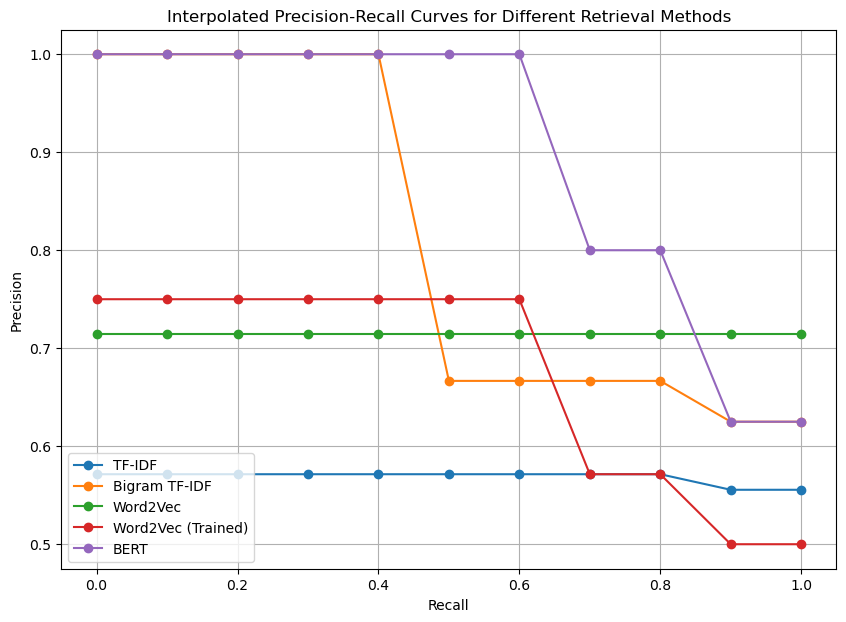

In [52]:
from matplotlib import pyplot as plt

# Prepare ground truth in pytrec_eval format (for a single query "q1")
qrel = {
    'q1': {f'doc{idx+1}': int(label) for idx, label in enumerate(corpus_relevancy_label)}
}

# Interpolated Precision-Recall curve recall levels
recall_levels = [round(i * 0.1, 1) for i in range(11)]

# Initialize evaluator with 'iprec_at_recall'
evaluator = pytrec_eval.RelevanceEvaluator(qrel, {'iprec_at_recall'})

# Prepare the plot
plt.figure(figsize=(10, 7))

# Loop over ranking methods
for method, ranking in ranking_methods.items():
    # Format run (system output) for pytrec_eval
    run = {
        'q1': {f'doc{doc_id}': float(len(ranking) - rank) for rank, doc_id in enumerate(ranking)}
    }

    # Evaluate using pytrec_eval
    results = evaluator.evaluate(run)

    # Extract interpolated precision at each recall level
    precisions = []
    for recall_level in recall_levels:
        iprec_key = f'iprec_at_recall_{recall_level:.2f}'
        precision = results['q1'].get(iprec_key, 0.0)
        precisions.append(precision)

    # Plot the curve
    plt.plot(recall_levels, precisions, marker='o', label=f'{method}')

# Configure the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Interpolated Precision-Recall Curves for Different Retrieval Methods')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [53]:
# Let's take a look at doc id 9 which most method failed to retrieve for hard negative case
print(corpus[8])

My teaching assistantship involves grading endless stacks of exams. Students keep emailing me for extensions with creative excuses. One claimed their dog sleeps on the laptop so they cannot use it for the exam. I was deprived of excuses for not completing my dissertation draft, and I might have got some good ones.


In [54]:
# For hard positive case
print(corpus[7])

The university gym membership was supposed to keep me healthy, but I've only used it once. I tried to attend a yoga class after staying up late for a deadline, but I fell asleep during the meditation. Maybe instead of the gym, my bed is more essential for keeping me healthy.


**Is they successfully retrieve the relevant documents?**
- None of the methods are 100% successfully retrieve the relevant documents. And the Bigram TF-IDF method is fail to score any document in this case.

**Compare these four methods using quantitative analysis and qualitative analysis.**
### Qualitative Analysis
- With the quantitative analysis, I use the AP for evaluation as the case is single query and binary relevance. The higher the AP, the better the method is. In this case the BERT method has the highest AP, followed by Bigram TF-IDF, Word2Vec, Word2Vec (Trained), and TF-IDF.
- With nDCG have same ranking as the AP, which is BERT > Bigram TF-IDF > Word2Vec > Word2Vec (Trained) > TF-IDF.

### Quantitative Analysis

#### TF-IDF
That the result show the the TF-IDF method is the worst among the four methods. From the case, the top five only the 1, 2 are relevant to the query. It show some effectiveness in the method, but the result is not good enough.

#### Bigram TF-IDF
Although the Bigram TF-IDF seems to have pretty high AP it this case, but from the case we can see the score are all resulted in 0.0. Which means the rank it output is identical to without reranking, in this case make it hit the positive of 1, 2, 5 in to 5th by "luck". This indicates that the Bigram TF-IDF model failed to capture any distinctive relevance scores for any documents. Perhaps, the documents are too short to have meaningful bigrams in this case.

#### Word2Vec
The trained model seen from the resulting slightly worse than the pre-trained model. But all of them are better than the TF-IDF. Surprisingly, the id 9 document have a pretty high score, which is not relevant to the query. This indicates that the Word2Vec model may have captured some semantic similarities between the query and the document, but it is not perfect and might be affect by some bias. But this will stil need further investigation.

#### BERT
The BERT model is the best among the four methods. It success capture the 1, 2, 5, 6 in just top 5th. Also specific to the document id 9, it have a pretty low score, which is not relevant to the query but the other method (Word2Vec, TF-IDF) all failed to do so. This indicates that the Attention mechanism have some special power in this case. From the document 9 we can see the key word "sleep" and "deprivation", but it not relative to each other. In the document 8, it do not contain the key word but it "meaning" is relevant to the query. This indicates that the BERT model may have captured some hidden semantic similarities behind the words, which is not captured by the other methods.

#### Conclusion
For the experiment, the BERT model is the best among the four methods. This show the attention base model have some ability that other method do not have which can understanding the real meaning relationship between the words.

## 💻 Assignment Submission 💻 
Write your code and display the results in this Jupyter Notebook. Then, export it as an HTML file and submit both the Jupyter Notebook and the HTML file to Cyber University. </br>
**Please ensure that the code is executed and the outputs are visible when exporting the HTML file.**